In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import known packages
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import gzip
import sys
sys.path.append('/Users/fradm/Desktop/fidelity-phase-tran')

# import adhoc packages
from qphaset.filters import SOBEL, SOBEL_X, bump_kernel, upsampling_base
from qphaset.fidelity import fidelity_laplacian, uhlmann_fidelity
from qs_mps.applications.Z2.utils import gstates_to_rdms_matrix_qs_mps
from qs_mps.utils import get_cx, get_cy

path = "marcos"
if path == "pc":
    parent_path = f"C:/Users/HP/Desktop/projects/1_Z2"
    # parent_path = "G:/My Drive/projects/1_Z2"
    path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor
else:
    raise SyntaxError("Path not valid. Choose among 'pc', 'mac', 'marcos'")



In [52]:
# *** Data sampling (Hamitonian parameters grid) ***

h_i, h_f, n = 0.6, 0.95, 15
h_i, h_f, n = 0.4, 1.0, 61
h_i, h_f, n = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,n)
# params = np.linspace(h_i, h_f, n), np.linspace(1/h_i, 1/h_f, 1)      # Floating phase detail ++

# params = map(lambda m: m.flatten(), np.meshgrid(*params, indexing='xy'))
# params = tuple(params)
# params = np.stack(params).T
params = np.array([[h, 1/h] for h in gs])
params

array([[0.8       , 1.25      ],
       [0.805     , 1.24223602],
       [0.81      , 1.2345679 ],
       [0.815     , 1.22699387],
       [0.82      , 1.2195122 ],
       [0.825     , 1.21212121],
       [0.83      , 1.20481928],
       [0.835     , 1.19760479],
       [0.84      , 1.19047619],
       [0.845     , 1.18343195],
       [0.85      , 1.17647059],
       [0.855     , 1.16959064],
       [0.86      , 1.1627907 ],
       [0.865     , 1.15606936],
       [0.87      , 1.14942529],
       [0.875     , 1.14285714],
       [0.88      , 1.13636364],
       [0.885     , 1.1299435 ],
       [0.89      , 1.12359551],
       [0.895     , 1.11731844],
       [0.9       , 1.11111111],
       [0.905     , 1.10497238],
       [0.91      , 1.0989011 ],
       [0.915     , 1.09289617],
       [0.92      , 1.08695652],
       [0.925     , 1.08108108],
       [0.93      , 1.07526882],
       [0.935     , 1.06951872],
       [0.94      , 1.06382979],
       [0.945     , 1.05820106],
       [0.

In [53]:
from qs_mps.mps_class import MPS

l = 6
l = 5
L = 30
chi = 256
chi = 128
R = 20
bc = "pbc"
model = "Z2_dual"
cx = get_cx(L, R)
cy = get_cy(l, bc)
precision = 3

if len(cx) == 0 and R == 0:
    sector = "vacuum_sector"
    cx = None
    cy = None
else:
    sector = f"{len(cx)}_particle(s)_sector"
    cx = cx
    cy = cy

gstates = []
for g in gs:
    lattice_mps = MPS(
        L=L, d=2**l, model=model, chi=chi, h=g, bc=bc
    )

    if sector != "vacuum_sector":
        lattice_mps.Z2.add_charges(cx, cy)
        lattice_mps.charges = lattice_mps.Z2.charges
        lattice_mps.Z2._define_sector()
    else:
        lattice_mps.Z2._define_sector()
    lattice_mps.load_sites(
        path=path_tensor, precision=precision, cx=cx, cy=cy
    )
    gstates.append(lattice_mps.sites)

Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.8, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.805, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.81, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.8150000000000001, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.8200000000000001, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particle(s)_sector'}
Metadata: {'L': 30, 'bc': 'pbc', 'chi': 128, 'cx': array([ 5, 25]), 'cy': array([0, 0]), 'h': 0.8250000000000001, 'l': 5, 'model': 'Z2_dual', 'sector': '2_particl

In [54]:
# with gzip.open(filename, 'rb') as f:
    # data = pickle.load(f)
# params = data['params']
# l, n = data['l'], data['n']
# gstates = data['gstates']


params_extent = np.concatenate([np.min(params, axis=0), np.max(params, axis=0)])
params_extent = tuple(params_extent[[0, 2, 1, 3]])
params_extent

(0.8, 1.0, 1.0, 1.25)

In [55]:
sites = [L // 2]
# sites = [L // 2 - 1, L // 2]
# sites = [L // 2 - 1, L // 2, L // 2 + 1]
# sites = [L // 2 - 2, L // 2 - 1, L // 2, L // 2 + 1]

rdms = gstates_to_rdms_matrix_qs_mps(gstates, sites=sites, shape=(n,1), d=2**l)

In [56]:
# TODO Fix this in the DMRG runs.
rdms = rdms[::-1]

In [57]:
rdms[0,0].shape

(32, 32)

In [58]:
rdms = rdms.reshape((n,2**l,2**l))
rdms_tot = rdms.tolist() + rdms.tolist() + rdms.tolist() 
rdms_tot = np.array(rdms_tot).reshape((n,3,2**l,2**l))
rdms_tot.shape

(41, 3, 32, 32)

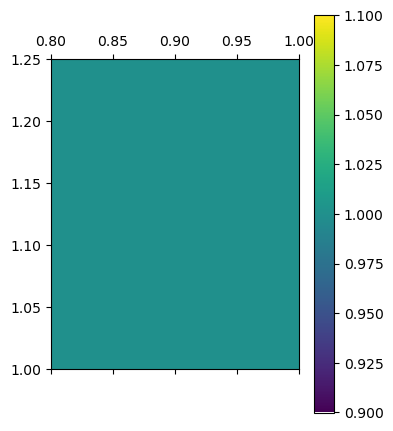

In [59]:
rdm_ranks = np.reshape(rdms, (-1, ) + rdms.shape[2:])
rdm_ranks = [np.linalg.matrix_rank(mat, hermitian=True) for mat in rdm_ranks]
rdm_ranks = np.reshape(rdm_ranks, rdms.shape[:2])
plt.matshow(rdm_ranks, origin='lower', extent=params_extent)
plt.colorbar()

In [60]:
eps = params[1, 0] - params[0, 0]
eps

0.0050000000000000044

In [61]:
# plot_grad_g_angle_stream(grad_g, params_extent=params_extent, theory_lines=False);

In [62]:
# plot_grad_g_angle4(grad_g, params_extent=params_extent);

In [63]:
# plot_grad_g_angle_sin_cos(grad_g, params_extent=params_extent);

In [90]:
# Grad laplacian filter with upsampling
kernel = bump_kernel(15, scale=2)
kernel = signal.convolve2d(kernel, SOBEL, boundary='symm', mode='same')

g = fidelity_laplacian(rdms_tot)
# TODO Optional upsampling
g_up = upsampling_base(g)
# TODO Exclude boundaries, re-eval domain.
grad_g = signal.convolve2d(g_up, kernel, boundary='symm', mode='same')

# # TODO Consider pixel centering.
# n1 = len(grad_g)
# n2 = len(grad_g)//2
# params1 = params_2d_lattice(params_extent[:2], params_extent[2:], n=n1)

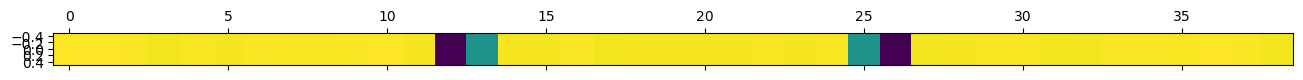

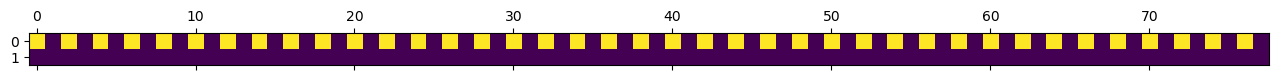

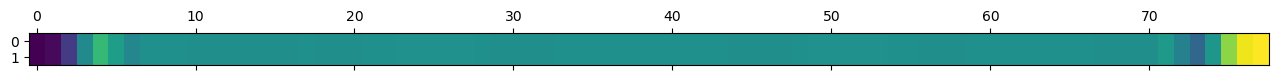

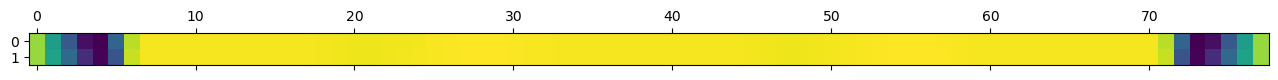

TypeError: Image data of dtype complex128 cannot be converted to float

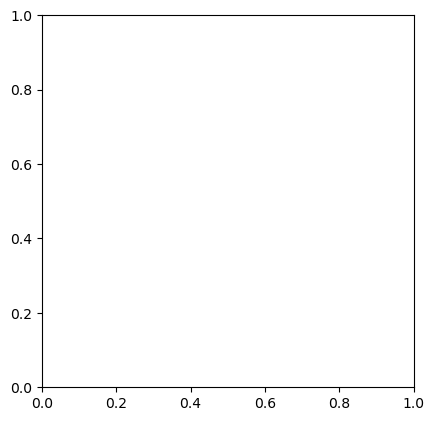

In [93]:
plt.matshow(g.T)
plt.show()
plt.matshow(g_up.T)
plt.show()
plt.matshow(grad_g.real.T)
plt.show()
plt.matshow(grad_g.imag.T)
plt.show()
plt.matshow(kernel)


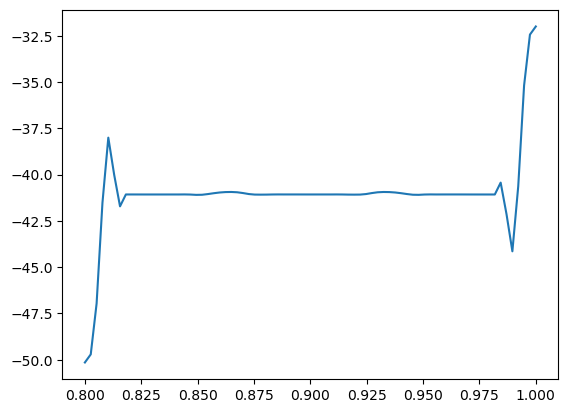

In [92]:
plt.plot(np.linspace(h_i,h_f,(n-2)*2), grad_g.real.T[-1])

In [78]:
grad_g.T[-1].shape

(78,)